In [1]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
#%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [2]:
import os
print(os.environ["LD_LIBRARY_PATH"])

$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, models, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, TimeDistributed, LSTM, SpatialDropout2D
from tensorflow.keras.optimizers import SGD, Adam

2022-10-30 19:17:16.242430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 19:17:16.678262: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-30 19:17:17.727708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/:/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-10-30 19:17:17.727788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

In [2]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-10-30 19:17:19.248427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 19:17:19.281426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:17:19.322587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:17:19.322783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-10-30 19:17:20.209508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:17:20.209776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:17:20.209945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Read the csv dataset to get the values for stage and discharge of the images

In [4]:
df = pd.read_csv("../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df = df[["Filename", "Stage", "Discharge", 'SensorTime']]

In [6]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df.head()

,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,2.99,916.0,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,2.99,916.0,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,2.96,873.0,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,2.94,846.0,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,2.94,846.0,2012-06-09 15:45:00,2012


### Remove outliers

In [7]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

We consider values equal to 0 as outliers because from the photos it doesn't seem that it would be possible that at this time we would have a value of 0 for stage or discharge

In [8]:
df.shape

(40148, 5)

### Scale the data

In [9]:
from sklearn.preprocessing import StandardScaler
from joblib import load

scaler = StandardScaler()
#scaler = load('std_scaler.joblib') # scaler with all the 42059 observations

In [10]:
df[["Stage", "Discharge"]] = scaler.fit_transform(df[["Stage", "Discharge"]])
df


,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,0.106063,-0.084154,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,0.106063,-0.084154,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,0.069235,-0.119960,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,0.044683,-0.142442,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,0.044683,-0.142442,2012-06-09 15:45:00,2012
...,...,...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,-0.446354,-0.485510,2019-10-11 09:00:00,2019
42055,StateLineWeir_20191011_Farrell_410.jpg,-0.446354,-0.485510,2019-10-11 10:00:00,2019
42056,StateLineWeir_20191011_Farrell_411.jpg,-0.446354,-0.485510,2019-10-11 11:00:00,2019
42057,StateLineWeir_20191011_Farrell_412.jpg,-0.446354,-0.485510,2019-10-11 12:00:00,2019


In [11]:
from joblib import dump
#dump(scaler, 'std_scaler.joblib')

## Create the dataset pipeline

In [12]:
IMG_SIZE = 224
#IMG_SIZE = 512
BATCH_SIZE = 32
FRAMES = 5

In [13]:
from dataset_transformer import make_dataset

In [14]:
path = "../../dataset/images_tmp_draw"

train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset(path, BATCH_SIZE, IMG_SIZE, FRAMES, df, 10, True, "cnn")

20304
7117
12727


2022-10-30 19:20:08.734097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:20:08.734291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:20:08.734431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:20:08.734614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:20:08.734757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [15]:
input_shape = 0
output_shape = 0

for image, stage_discharge in train_ds.take(1):
    print(image.numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

(32, 224, 224, 3)
(32, 2)


In [16]:
print(input_shape)
print(output_shape)

(224, 224, 3)
(2,)


## Check images

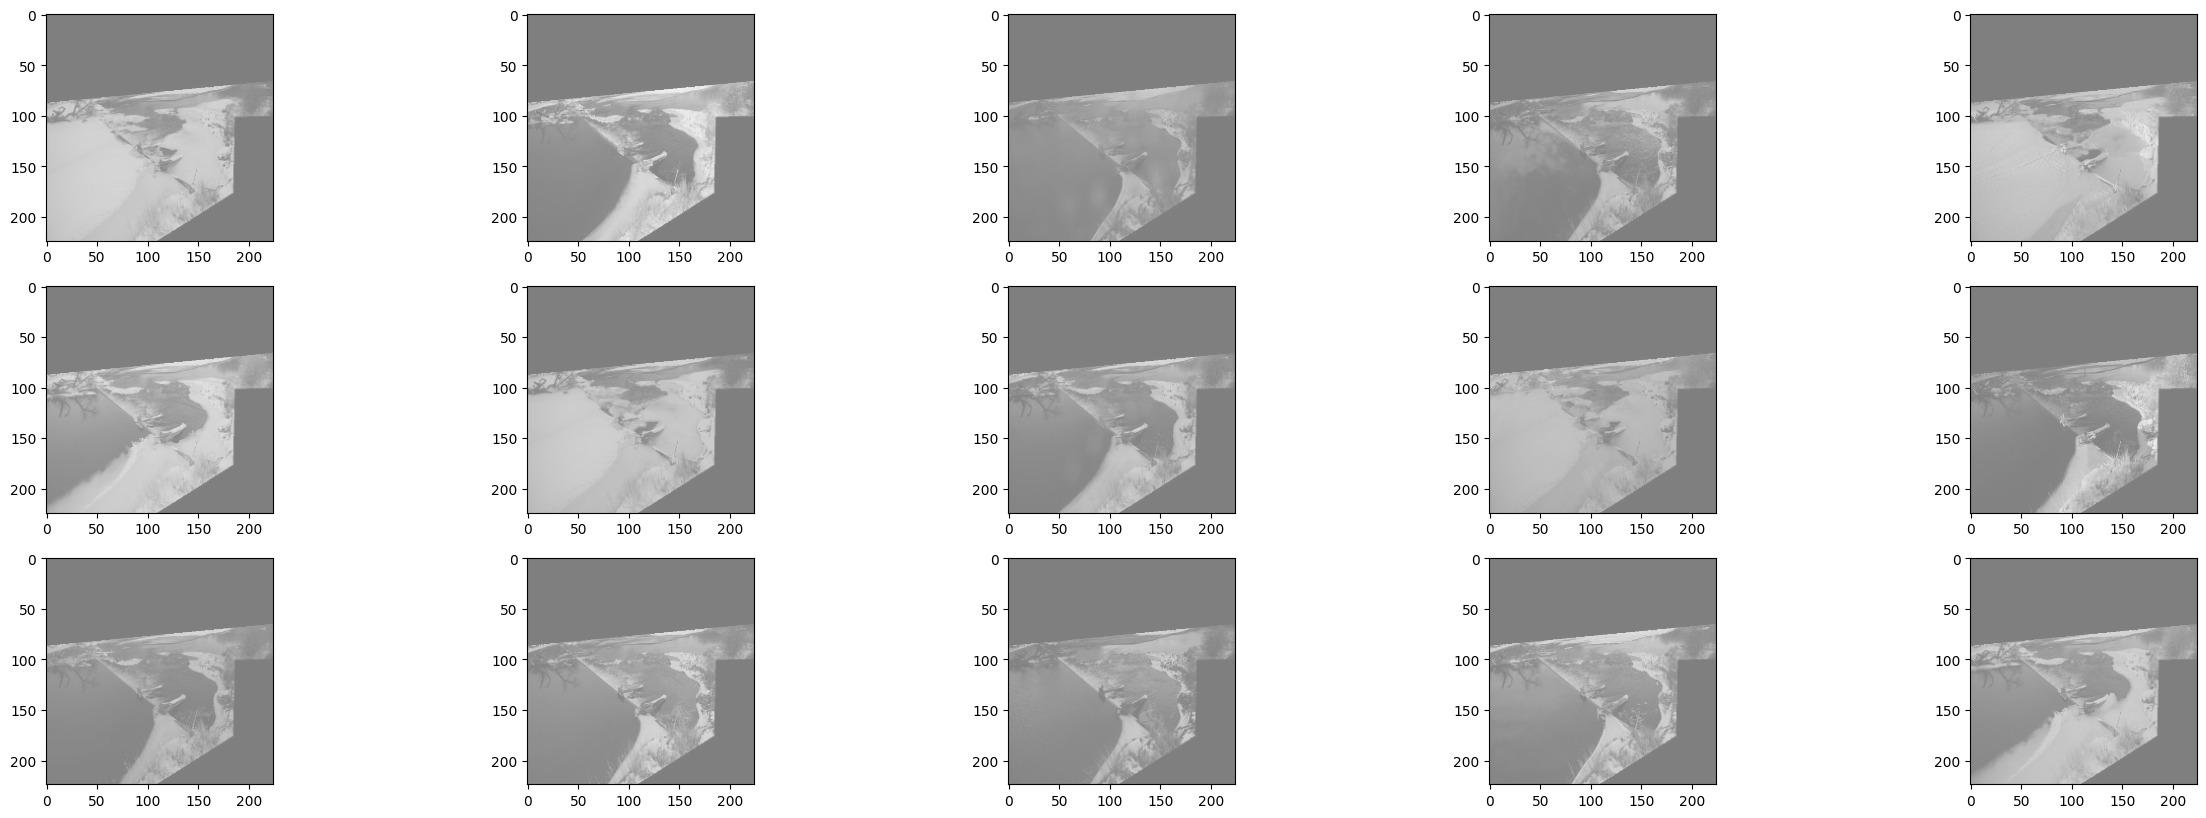

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30, 10))

for image, stage_discharge in test_ds.take(1):
    images = image[:15]
    for img, ax in zip(images, ax.flatten()):
        #img = img.numpy()[0]
        img = img.numpy()
        img = img / 2 + 0.5     # unnormalize
        ax.imshow(img)

plt.show()

## Create model

In [102]:
def create_model(input_shape, output_shape, option="normal"):
    model = Sequential()

    if option == "transfer":
        base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)
        base_model.trainable = False
        base_model._name = 'base_model_ResNet50'

        model.add(base_model)
        model.add(Dropout(0.3))
        model.add(GlobalAveragePooling2D())

        model.add(Dense(512, activation='elu'))
        model.add(Dense(512, activation='elu'))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(128, activation='elu'))
    elif option == "normal":
        model.add(Input(shape=input_shape))
        
        """model.add(Conv2D(16, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(GlobalAveragePooling2D())

        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(64, activation='elu'))"""

        model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', activation="elu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation="elu", padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same'))
        #model.add(AveragePooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(256, activation='tanh'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='tanh'))
        model.add(Dense(64, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
    elif option == "cnn/lstm":
        model.add(Input(shape=input_shape))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', activation=LeakyReLU())))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(4, 4))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation=LeakyReLU(), padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation=LeakyReLU(0.2), padding='same')))
        model.add(TimeDistributed(AveragePooling2D(pool_size=(2, 2))))
        

        model.add(TimeDistributed(GlobalAveragePooling2D()))

        model.add(LSTM(10))

        model.add(Dense(64, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        
    model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [103]:
model = create_model(input_shape, output_shape[0], "normal")
#model = create_model(input_shape, output_shape[1], "cnn/lstm")

In [104]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 112, 112, 32)      1568      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        16416     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 12, 12, 64)       

In [105]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [106]:
sgd = SGD(learning_rate=0.01, decay=1e-3, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)

compile_model('mse', sgd,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [107]:
def fit_model(training_values, validation_values=None, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [108]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_cnn_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)


In [109]:
# batch_size = 0 because we already have batch size in tf dataset
model_h = fit_model(train_ds, val_ds, epochs=60, steps=np.ceil(train_size / BATCH_SIZE), val_steps=np.ceil(val_size / BATCH_SIZE), callbacks=[tensorboard_callback, checkpoint_callback, es_callback])

Epoch 1/60
635/635 [==============================] - ETA: 0s - loss: 0.1610 - mse: 0.1610 - rmse: 0.4013 - mae: 0.2118 - mape: 68.5414
Epoch 1: val_loss improved from inf to 0.04874, saving model to model_weights/20221030-202000_cnn_best_weights.hdf5
635/635 [==============================] - 31s 48ms/step - loss: 0.1610 - mse: 0.1610 - rmse: 0.4013 - mae: 0.2118 - mape: 68.5414 - val_loss: 0.0487 - val_mse: 0.0487 - val_rmse: 0.2208 - val_mae: 0.1577 - val_mape: 41.4325
Epoch 2/60
635/635 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0190 - rmse: 0.1379 - mae: 0.0948 - mape: 38.0835
Epoch 2: val_loss improved from 0.04874 to 0.03504, saving model to model_weights/20221030-202000_cnn_best_weights.hdf5
635/635 [==============================] - 27s 43ms/step - loss: 0.0190 - mse: 0.0190 - rmse: 0.1379 - mae: 0.0948 - mape: 38.0835 - val_loss: 0.0350 - val_mse: 0.0350 - val_rmse: 0.1872 - val_mae: 0.1340 - val_mape: 39.6013
Epoch 3/60
634/635 [======================

## Evaluate model

In [110]:
print(date_actual)

20221030-202000


In [111]:
best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5')
#best_model = models.load_model(f'best_models_weights/cnn_best_weights_v9.hdf5')


In [112]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [113]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=np.ceil(test_size / BATCH_SIZE))

398/398 [==============================] - 12s 30ms/step - loss: 0.0505 - mse: 0.0505 - rmse: 0.2246 - mae: 0.1389 - mape: 72.7527


In [114]:
#predictions = best_model.predict(test_ds, steps=np.ceil(test_size / BATCH_SIZE))

In [115]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge.numpy()
	predictions_values = predictions
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values.numpy())):
		print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")

1/1 [==============================] - 0s 88ms/step
441.19266182980726
3243.6085036341224
pred stage: 2.074333429336548, actual stage: 2.42
pred discharge: 267.8599853515625, actual discharge: 210.0
pred stage: 2.1716480255126953, actual stage: 2.24
pred discharge: 227.58538818359375, actual discharge: 193.9999999999999
pred stage: 2.097628116607666, actual stage: 2.24
pred discharge: 134.73583984375, actual discharge: 193.9999999999999
pred stage: 1.9582111835479736, actual stage: 2.46
pred discharge: 116.59221649169922, actual discharge: 209.0
pred stage: 2.164323091506958, actual stage: 2.24
pred discharge: 195.36407470703125, actual discharge: 193.9999999999999
pred stage: 2.0977611541748047, actual stage: 2.25
pred discharge: 154.81903076171875, actual discharge: 198.0
pred stage: 2.106117010116577, actual stage: 2.25
pred discharge: 164.81689453125, actual discharge: 199.0
pred stage: 2.0872802734375, actual stage: 2.25
pred discharge: 146.6630859375, actual discharge: 198.0
pred

### Residual analysis

In [116]:
y_predictions = np.empty(shape=(1, 2))
y_real = np.empty(shape=(1, 2))

"""for image, stage_discharge in test_ds.take(100):
    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))
    y_real = np.concatenate((y_real, stage_discharge.numpy()))"""

'for image, stage_discharge in test_ds.take(100):\n    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))\n    y_real = np.concatenate((y_real, stage_discharge.numpy()))'

/tmp/ipykernel_23436/3264406076.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")


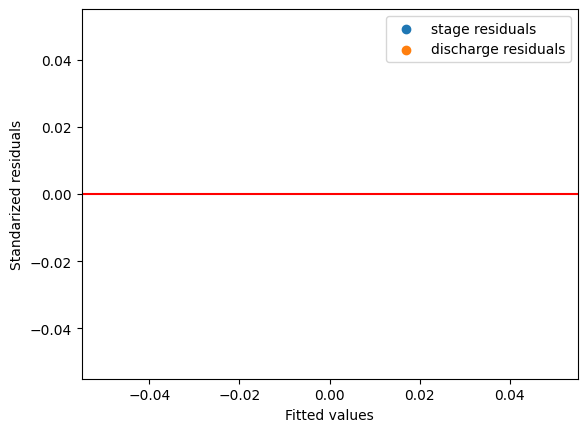

In [117]:
residuals = y_real - y_predictions
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_real])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[1] for i in y_real])
residual_discharge = np.array([i[1] for i in residuals])

plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Standarized residuals")

plt.legend()
plt.show()

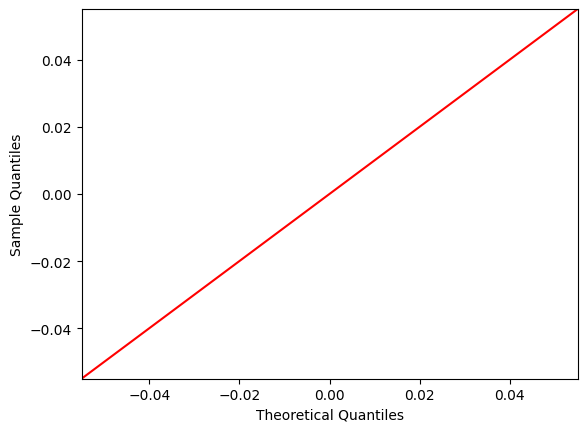

In [118]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

/tmp/ipykernel_23436/1192211388.py:1: RuntimeWarning: divide by zero encountered in divide
  figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')


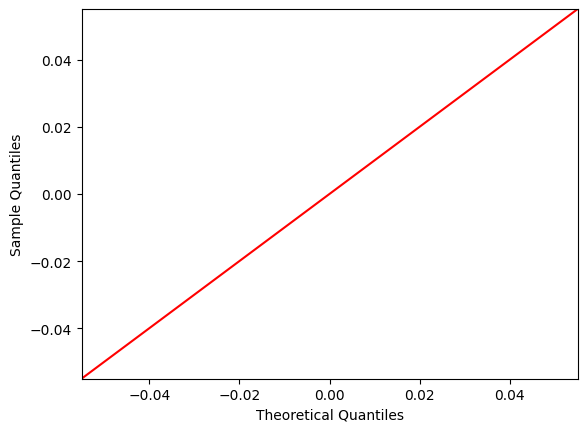

In [119]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

In [120]:
import seaborn as sns

#sns.histplot(residuals, kde=True, bins = 10)

In [121]:
stat, pval = normal_ad(residual_stage)
print("p-value:", pval)

if pval<0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")

p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [122]:
stat, pval = normal_ad(residual_discharge)
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Visualize layers

In [123]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [124]:
activations = activation_model.predict(test_ds.take(1)) 

1/1 [==============================] - 0s 212ms/step


conv2d_32
max_pooling2d_14
conv2d_33
max_pooling2d_15
conv2d_34
conv2d_35
conv2d_36
max_pooling2d_16
conv2d_37
conv2d_38
max_pooling2d_17
flatten_4


/tmp/ipykernel_23436/1031377702.py:24: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


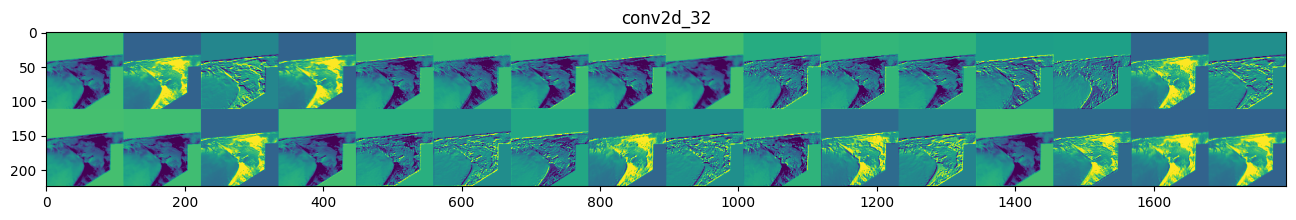

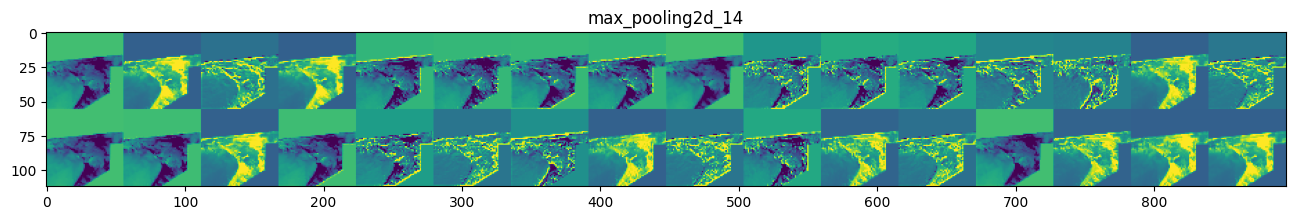

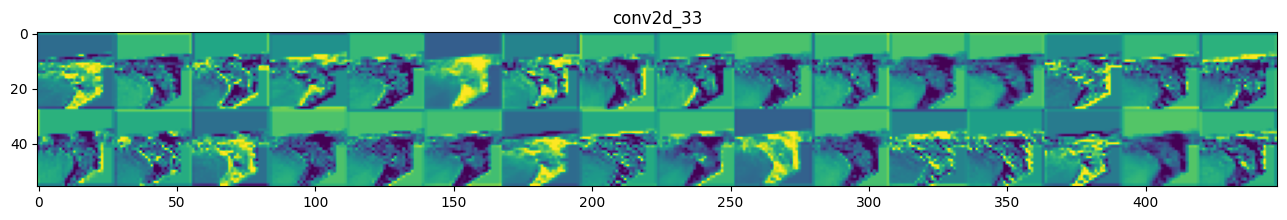

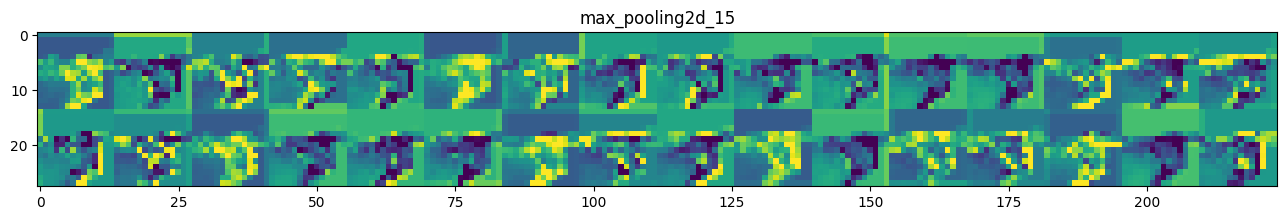

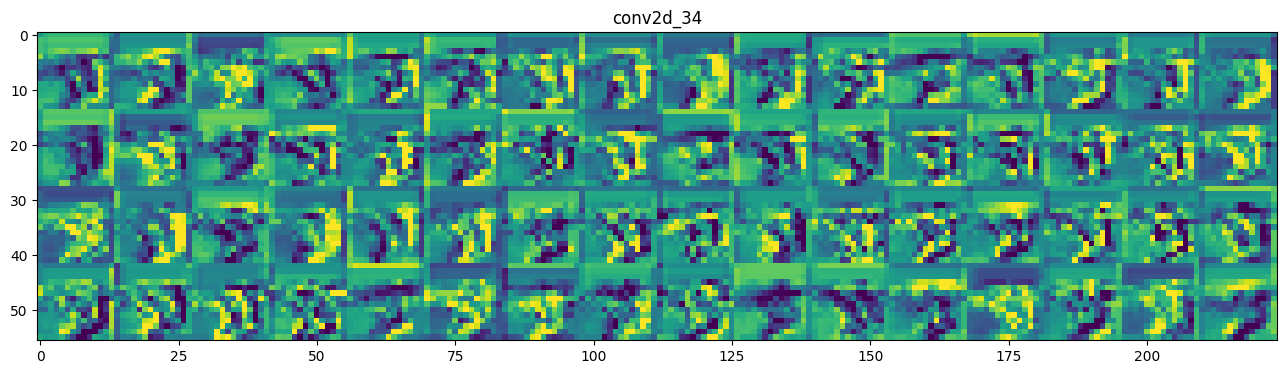

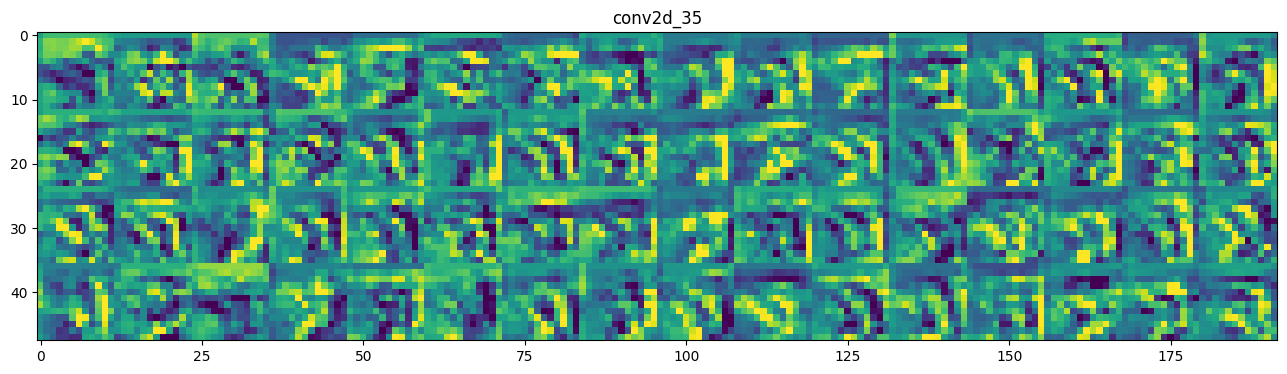

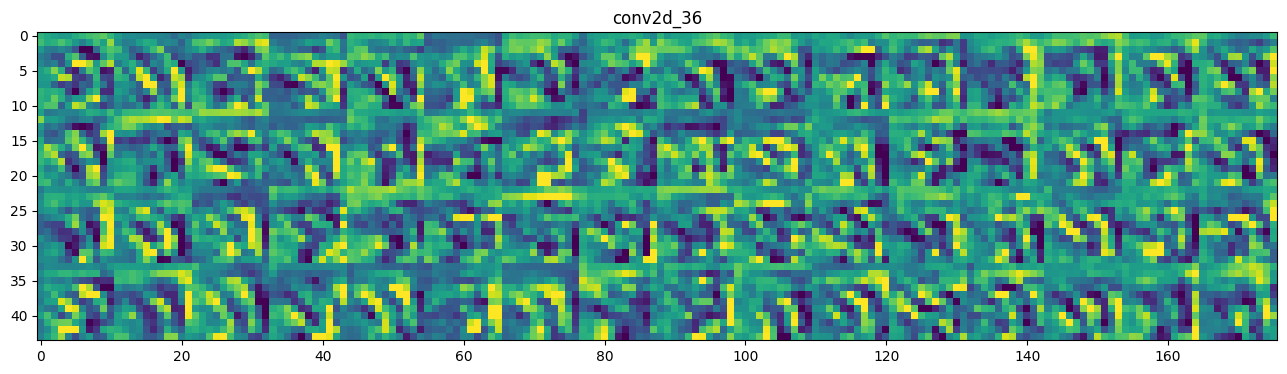

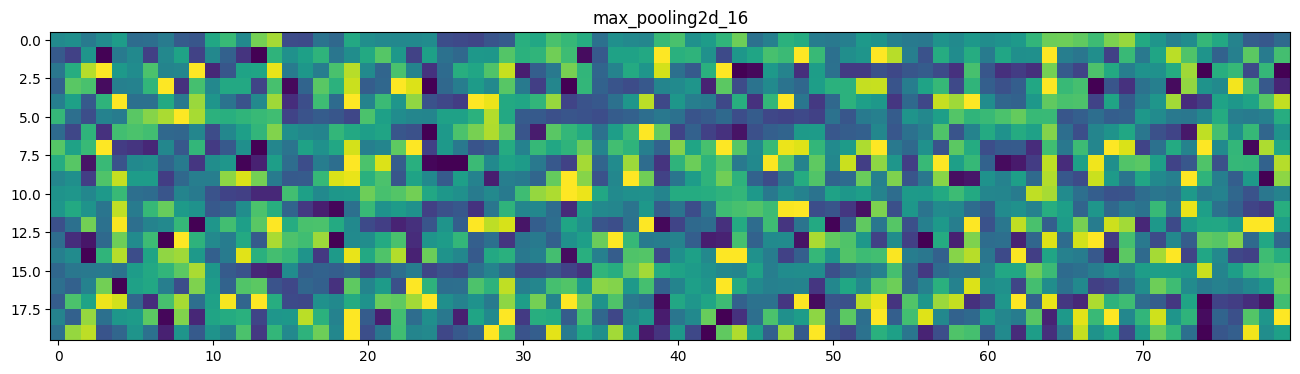

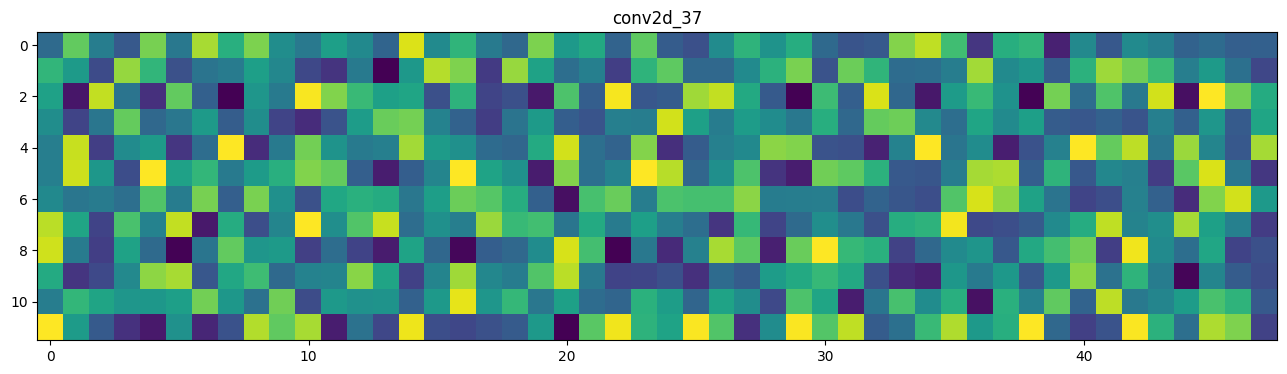

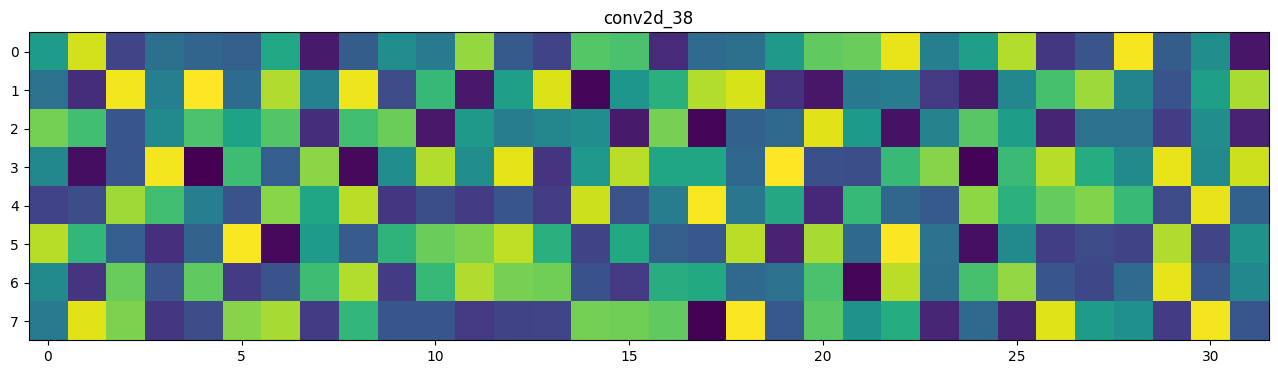

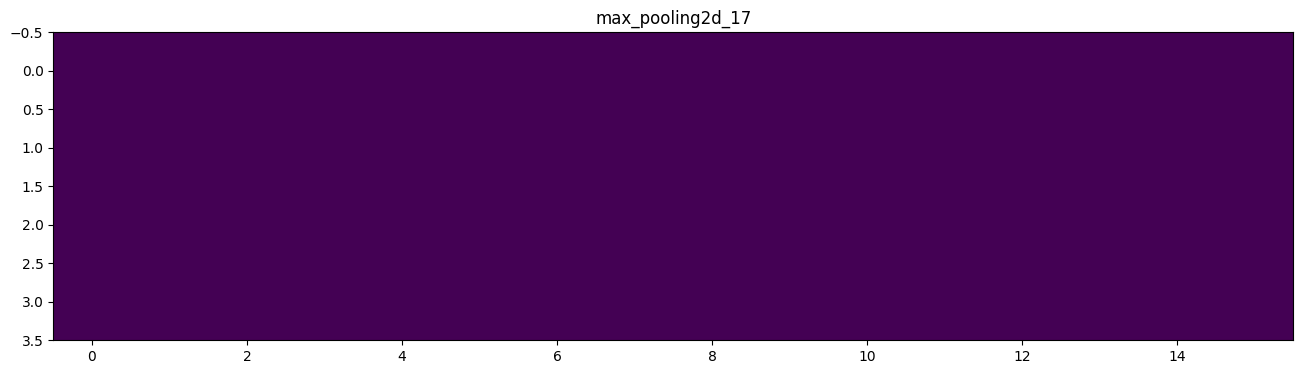

In [125]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if "flatten" in layer_name or "dense" in layer_name: break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')